<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/CNN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Network (CNN)

Classification of handwritten numbers (MNIST) by CNN

Loss: Labels Smoothing

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

In [18]:
# load MNIST data
train_Dataset = dsets.MNIST(
      root='./data',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

test_dataset = dsets.MNIST(
      root='./data',  
      train=False, 
      transform=transforms.ToTensor(),
      download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_Dataset,   # 分割するデータセット
      [48000, 12000])  # 分割数
 
print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))  
print('test_dataset = ', len(test_dataset))


train_dataset =  48000
valid_dataset =  12000
test_dataset =  10000


In [19]:
# set data loader
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=64,  # ミニバッチの指定
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数

valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=64, 
      shuffle=False,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=64, 
      shuffle=False,
      num_workers=2)


In [20]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Without Label Smoothing

In [21]:

net = Network()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

if torch.cuda.is_available():
  net.cuda()

print('Network architecture for CNN\n', net)


# optimizing
smoothing = 0.0
criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
#optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)


cuda
Network architecture for CNN
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
###  training
print ('training start ...')
num_epochs = 100   

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
#        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization
    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...
Epoch [1/100] train Loss: 0.0079, train acc: 0.8461 | val_loss: 0.0079, val_acc: 0.8474
Epoch [2/100] train Loss: 0.0047, train acc: 0.9121 | val_loss: 0.0048, val_acc: 0.9087
Epoch [3/100] train Loss: 0.0037, train acc: 0.9300 | val_loss: 0.0038, val_acc: 0.9297
Epoch [4/100] train Loss: 0.0030, train acc: 0.9442 | val_loss: 0.0031, val_acc: 0.9423
Epoch [5/100] train Loss: 0.0026, train acc: 0.9522 | val_loss: 0.0027, val_acc: 0.9498
Epoch [6/100] train Loss: 0.0022, train acc: 0.9599 | val_loss: 0.0023, val_acc: 0.9594
Epoch [7/100] train Loss: 0.0021, train acc: 0.9629 | val_loss: 0.0022, val_acc: 0.9617
Epoch [8/100] train Loss: 0.0019, train acc: 0.9663 | val_loss: 0.0020, val_acc: 0.9654
Epoch [9/100] train Loss: 0.0018, train acc: 0.9681 | val_loss: 0.0019, val_acc: 0.9668
Epoch [10/100] train Loss: 0.0017, train acc: 0.9714 | val_loss: 0.0018, val_acc: 0.9700
Epoch [11/100] train Loss: 0.0019, train acc: 0.9636 | val_loss: 0.0021, val_acc: 0.9613
Epoch [12/1

In [23]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 


test_accuracy: 97.81 %


In [24]:

# save weights (You can save the model by uncomment the following line)
import os
if not os.path.exists('trained_models'):
    os.mkdir('trained_models')
torch.save(net.state_dict(), './trained_models/CNN_mnist_net.pth')

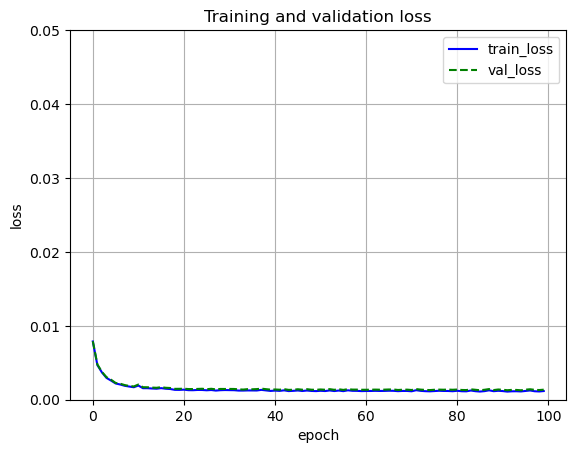

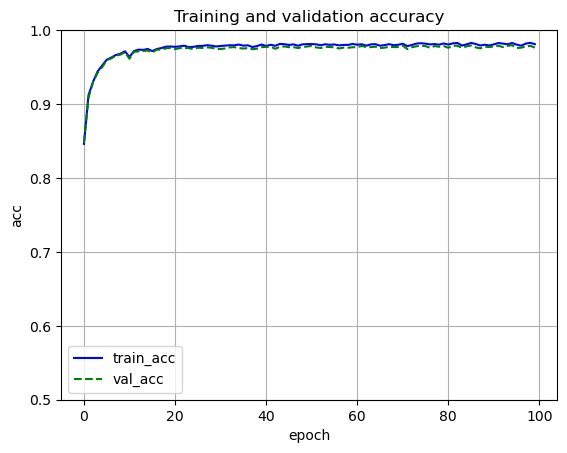

In [25]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.05])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('CNN_mnist_loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.5, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('CNN_mnist_acc.png')
plt.show()

Visualize the output features by using PCA

In [26]:
# ======== eval_mode (train samples) ======
net.eval()
train_features = np.zeros((len(train_dataset), 10))
train_labels = np.zeros(len(train_dataset), dtype=int)

with torch.no_grad():
    total = 0
    acc = 0
    i = 0
    for images, labels in train_loader:        
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
        len_batch = len(images)
        train_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        train_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch
    print('train_accuracy: {} %'.format(100 * acc / total)) 

print(train_features.shape)
print(train_labels.shape)

train_accuracy: 98.09791666666666 %
(48000, 10)
(48000,)


In [27]:
# ======== eval_mode (test samples) ======
net.eval()
test_features = np.zeros((len(test_dataset), 10))
test_labels = np.zeros(len(test_dataset), dtype=int)

with torch.no_grad():
    total = 0
    acc = 0
    i = 0
    for images, labels in test_loader:        
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
        len_batch = len(images)
        test_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        test_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch
    print('test_accuracy: {} %'.format(100 * acc / total)) 

print(test_features.shape)
print(test_labels.shape)

test_accuracy: 97.81 %
(10000, 10)
(10000,)


In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## PCA
pca = PCA(n_components=2)
#pca = PCA(n_components=2, svd_solver='randomized')
train_pca_score = pca.fit(train_features).transform(train_features)
#print(pca.singular_values_)
print('Explained Variance Ratio\n', pca.explained_variance_ratio_)

test_pca_score = pca.transform(test_features)
#print(train_pca_score)
#print(test_pca_score)

Explained Variance Ratio
 [0.31421535 0.21977604]


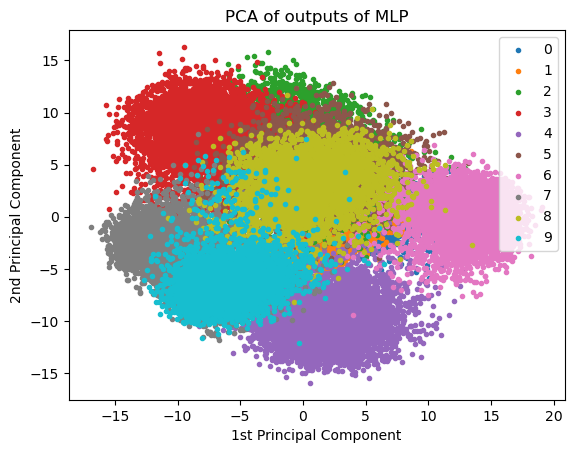

In [29]:
nclass = 10
#colors = np.random.rand(nclass) * 500000000000
colors = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']

## plot
plt.figure()
for k in range(nclass):
    plt.scatter(train_pca_score[train_labels == k, 0], train_pca_score[train_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of outputs of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_train_features.png')
plt.show()

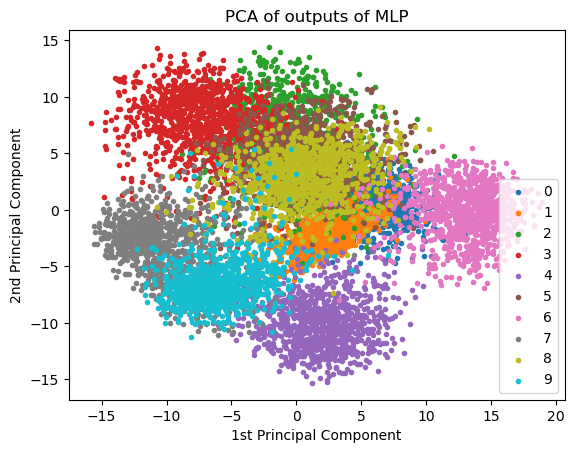

In [30]:

## plot
plt.figure()
for k in range(nclass):
    plt.scatter(test_pca_score[test_labels == k, 0], test_pca_score[test_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of outputs of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_test_features.png')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix

test_predicted = test_features.argmax(1)
#print(test_predicted)
#print(test_labels)
print('Confusion Matrix for Test Samples\n', confusion_matrix(test_labels, test_predicted))

Confusion Matrix for Test Samples
 [[ 976    1    1    0    0    0    0    1    1    0]
 [   0 1126    4    1    0    0    3    0    1    0]
 [   8    2 1009    3    0    0    0    5    5    0]
 [   1    1    1  998    0    1    0    4    3    1]
 [   1    0    1    0  977    0    1    0    0    2]
 [   5    1    0   16    1  856    6    1    4    2]
 [   8    3    1    1    4    1  939    0    1    0]
 [   1    4   12    3    5    0    0  995    2    6]
 [   7    0    4    5    4    1    3    3  944    3]
 [   8    7    1    9   17    0    0    5    1  961]]


# Visualization of each dimension of the output feature vector as Histogram

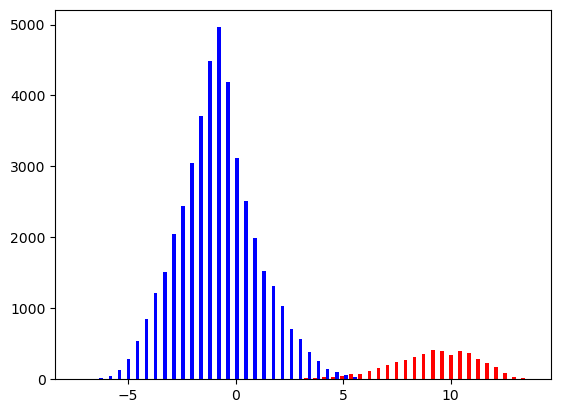

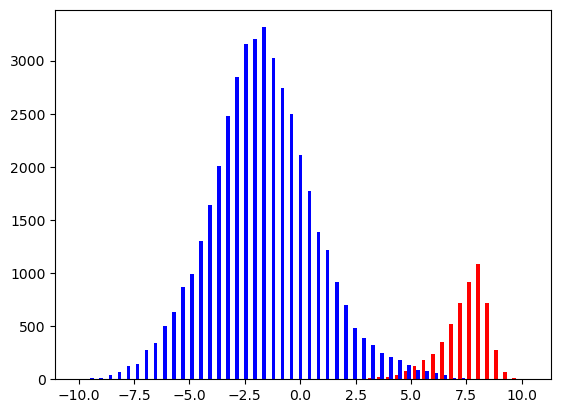

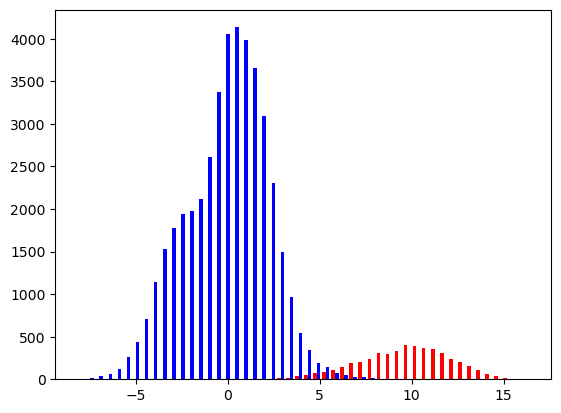

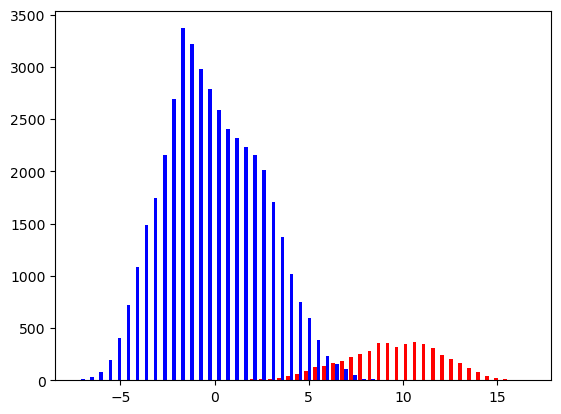

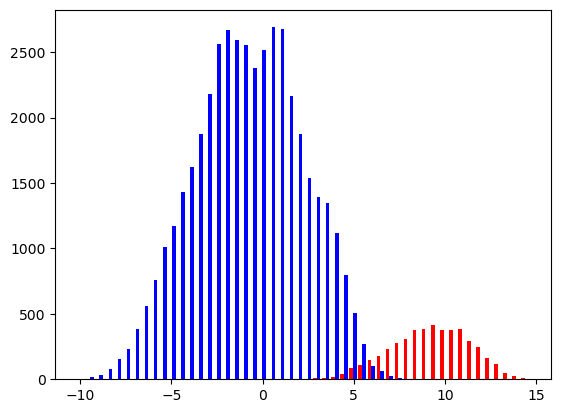

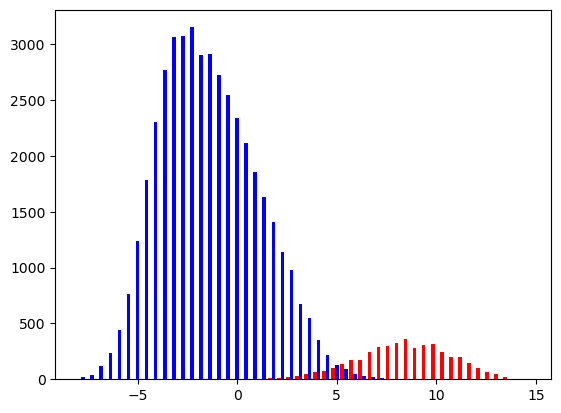

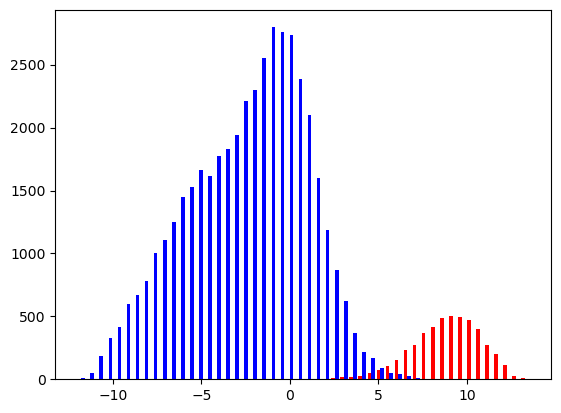

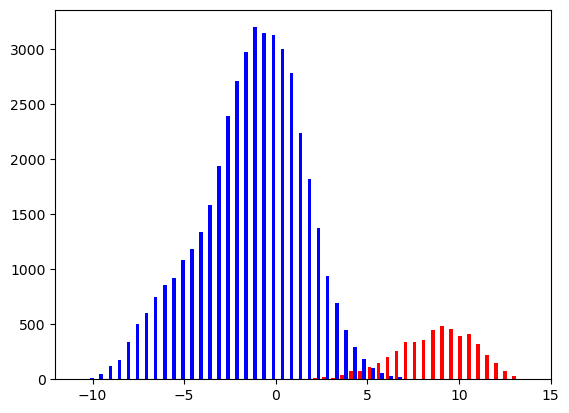

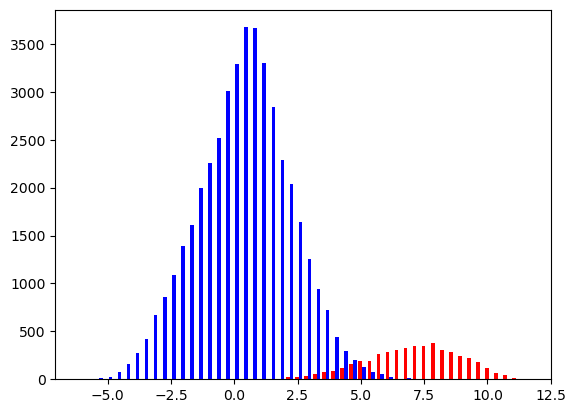

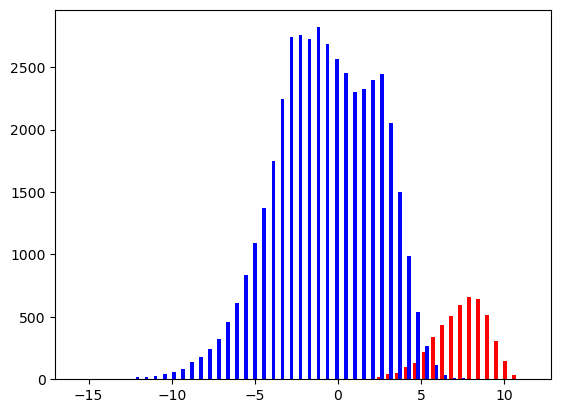

In [32]:
# Histogram of each output values
for k in range(nclass):
  plt.hist([train_features[train_labels == k, k], train_features[train_labels != k, k]], bins=50, color=['red', 'blue'])
  plt.show()

## With Label Smoothin

In [33]:

net = Network()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

if torch.cuda.is_available():
  net.cuda()

print('Network architecture for CNN\n', net)


# optimizing
smoothing = 0.1
criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
#optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)


cuda
Network architecture for CNN
 Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [34]:
###  training
print ('training start ...')

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
#        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization
    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...
Epoch [1/100] train Loss: 0.0149, train acc: 0.8581 | val_loss: 0.0149, val_acc: 0.8580
Epoch [2/100] train Loss: 0.0127, train acc: 0.9088 | val_loss: 0.0128, val_acc: 0.9084
Epoch [3/100] train Loss: 0.0117, train acc: 0.9308 | val_loss: 0.0118, val_acc: 0.9284
Epoch [4/100] train Loss: 0.0111, train acc: 0.9438 | val_loss: 0.0112, val_acc: 0.9408
Epoch [5/100] train Loss: 0.0107, train acc: 0.9515 | val_loss: 0.0108, val_acc: 0.9496
Epoch [6/100] train Loss: 0.0104, train acc: 0.9593 | val_loss: 0.0105, val_acc: 0.9582
Epoch [7/100] train Loss: 0.0103, train acc: 0.9611 | val_loss: 0.0104, val_acc: 0.9577
Epoch [8/100] train Loss: 0.0101, train acc: 0.9655 | val_loss: 0.0102, val_acc: 0.9645
Epoch [9/100] train Loss: 0.0101, train acc: 0.9639 | val_loss: 0.0102, val_acc: 0.9609
Epoch [10/100] train Loss: 0.0099, train acc: 0.9685 | val_loss: 0.0101, val_acc: 0.9670
Epoch [11/100] train Loss: 0.0099, train acc: 0.9689 | val_loss: 0.0100, val_acc: 0.9692
Epoch [12/1

In [35]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 


test_accuracy: 98.06 %


In [36]:

# save weights (You can save the model by uncomment the following line)
import os
if not os.path.exists('trained_models'):
    os.mkdir('trained_models')
torch.save(net.state_dict(), './trained_models/CNN_mnist_labelsmoothing_net.pth')

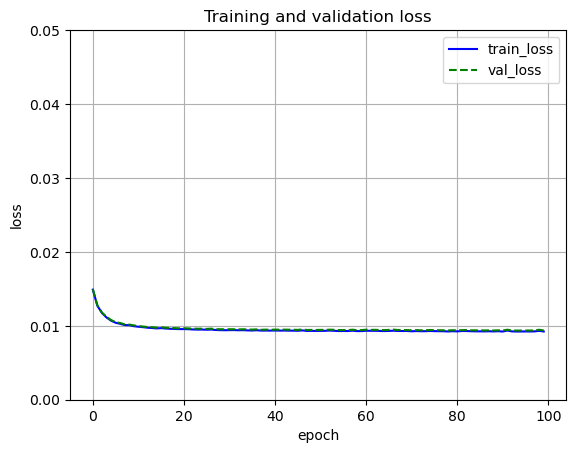

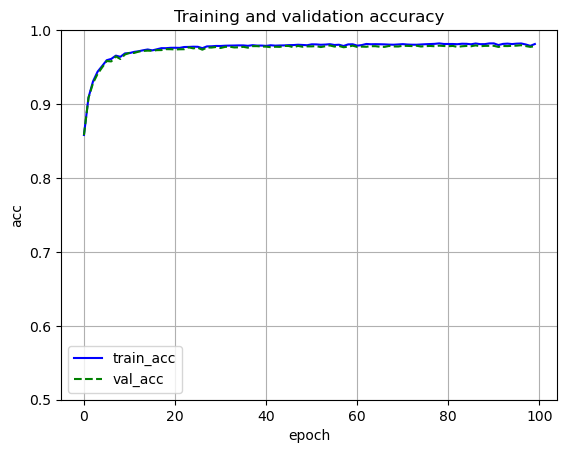

In [37]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.05])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('CNN_mnist_loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.5, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('CNN_mnist_acc.png')
plt.show()

Visualize the output features by using PCA

In [38]:
# ======== eval_mode (train samples) ======
net.eval()
train_features = np.zeros((len(train_dataset), 10))
train_labels = np.zeros(len(train_dataset), dtype=int)

with torch.no_grad():
    total = 0
    acc = 0
    i = 0
    for images, labels in train_loader:        
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
        len_batch = len(images)
        train_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        train_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch
    print('train_accuracy: {} %'.format(100 * acc / total)) 

print(train_features.shape)
print(train_labels.shape)

train_accuracy: 98.11875 %
(48000, 10)
(48000,)


In [39]:
# ======== eval_mode (test samples) ======
net.eval()
test_features = np.zeros((len(test_dataset), 10))
test_labels = np.zeros(len(test_dataset), dtype=int)

with torch.no_grad():
    total = 0
    acc = 0
    i = 0
    for images, labels in test_loader:        
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
        len_batch = len(images)
        test_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        test_labels[i:i+len_batch] = labels.cpu().detach().numpy()
        i += len_batch
    print('test_accuracy: {} %'.format(100 * acc / total)) 

print(test_features.shape)
print(test_labels.shape)

test_accuracy: 98.06 %
(10000, 10)
(10000,)


In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## PCA
pca = PCA(n_components=2)
#pca = PCA(n_components=2, svd_solver='randomized')
train_pca_score = pca.fit(train_features).transform(train_features)
#print(pca.singular_values_)
print('Explained Variance Ratio\n', pca.explained_variance_ratio_)

test_pca_score = pca.transform(test_features)
#print(train_pca_score)
#print(test_pca_score)

Explained Variance Ratio
 [0.16695713 0.15081471]


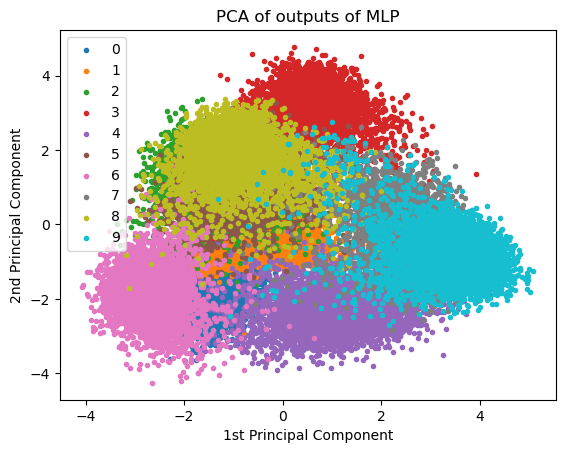

In [41]:
nclass = 10
#colors = np.random.rand(nclass) * 500000000000
colors = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']

## plot
plt.figure()
for k in range(nclass):
    plt.scatter(train_pca_score[train_labels == k, 0], train_pca_score[train_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of outputs of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_labelsmoothing_train_features.png')
plt.show()

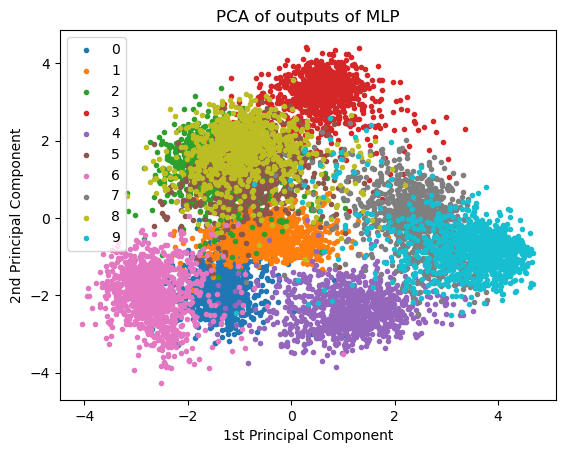

In [42]:

## plot
plt.figure()
for k in range(nclass):
    plt.scatter(test_pca_score[test_labels == k, 0], test_pca_score[test_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of outputs of MLP')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('MLP_mnist_labelsmoothing_test_features.png')
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix

test_predicted = test_features.argmax(1)
#print(test_predicted)
#print(test_labels)
print('Confusion Matrix for Test Samples\n', confusion_matrix(test_labels, test_predicted))

Confusion Matrix for Test Samples
 [[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1124    3    2    0    0    4    1    1    0]
 [   6    0 1010    2    0    0    0    6    8    0]
 [   1    0    1  996    0    3    0    4    4    1]
 [   1    0    2    0  959    0    4    2    2   12]
 [   3    0    0    8    0  870    5    1    4    1]
 [   6    3    0    1    1    1  946    0    0    0]
 [   1    2   12    4    0    0    0 1002    2    5]
 [   3    0    1    5    1    1    3    2  955    3]
 [   5    6    1   14    3    2    0    4    3  971]]


# Visualization of each dimension of the output feature vector as Histogram

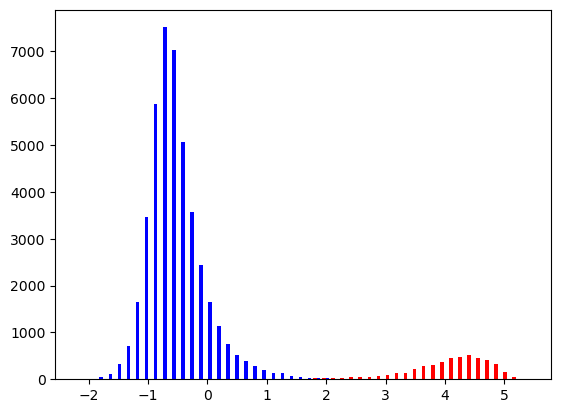

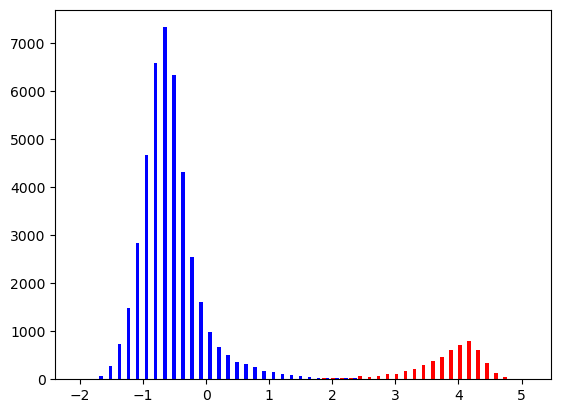

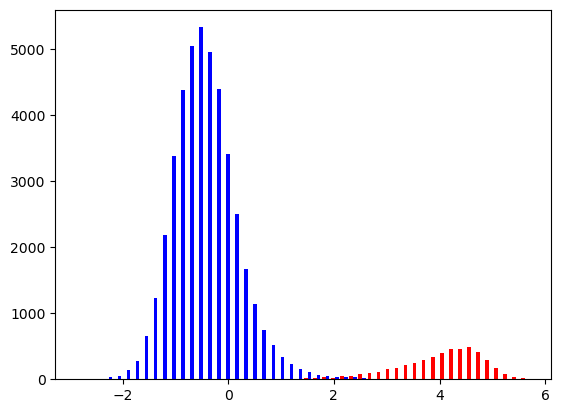

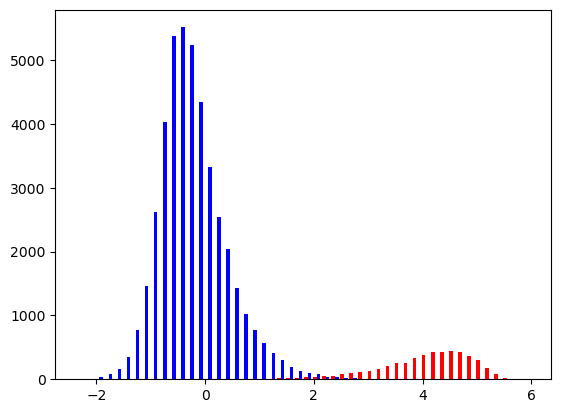

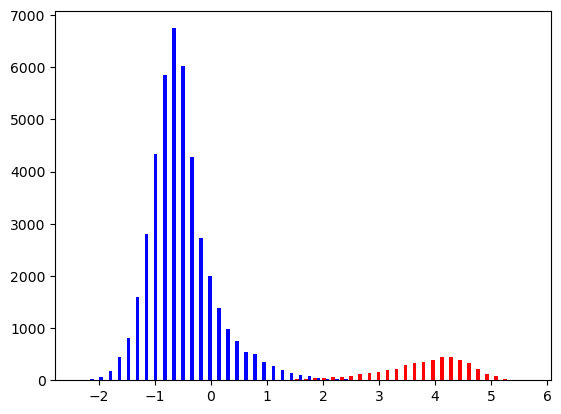

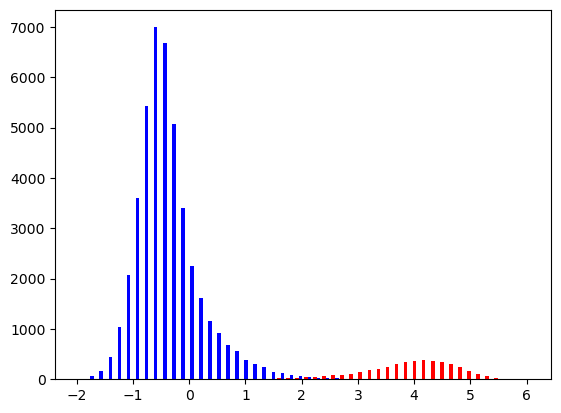

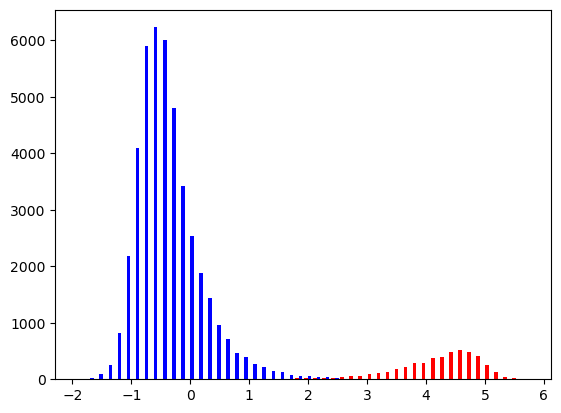

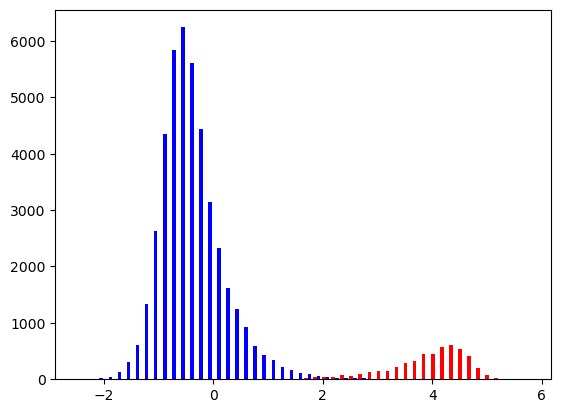

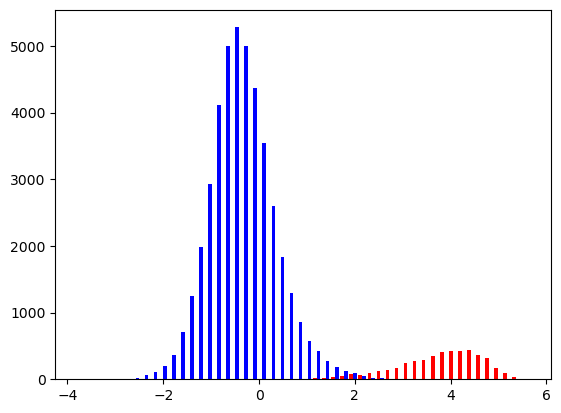

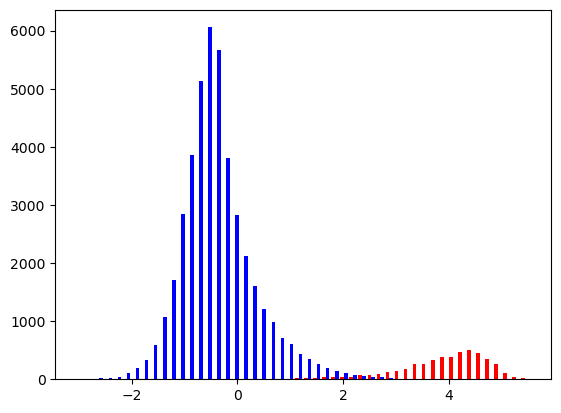

In [44]:
# Histogram of each output values
for k in range(nclass):
  plt.hist([train_features[train_labels == k, k], train_features[train_labels != k, k]], bins=50, color=['red', 'blue'])
  plt.show()